# Intro

For this project, I will be looking at the Data from the 2019 Data Science Bowl on Kaggle (link: https://www.kaggle.com/c/data-science-bowl-2019/overview). You can see my Kaggle Submission here: https://www.kaggle.com/rkjiwa/kernel773761685d.

For this challenge, we are provided with gameplay data for a early childhood education game, PBS KIDS Measure Up!. Our objective is to take test data, and create a prediction as to what accuracy group (0,1,2 or 3) a child scores in for the last assessment attempt. The expectation is a file containing the installation_id (represents each application install) along with the predicted accuracy group. The submissions will then be evaluated on a quadratic weighted kappa to measure how closely the prediction and the actual test accuracies agree. 


|Accuracy Groups| Meaning|
|----|----|
| 0 | Assessment was never solved|
| 1 | Assessment was solved after 3 or more attempts|
| 2 | Assesment was solved on second attempt|
| 3 | Assessment was solved on the first attempt|


| Files | What they contain |
|---|---|
| train.csv | training data|
| train_labels.csv | contains accuracy groups for training data |
| test.csv | testing data - used to generate predictions |
| specs.csv | gives info of specification of various event types|
| sample_submission.csv | sample of submission in correct format |


| Columns (for train.csv, test.csv)| Description (From Kaggle)|
|---|---|
|event_id | Randomly generated unique identifier for the event type. Maps to event_id column in specs table.|
|game_session|Randomly generated unique identifier grouping events within a single game or video play session.|
|timestamp|Client-generated datetime|
|event_data|Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.|
|installation_id | Randomly generated unique identifier grouping game sessions within a single installed application instance.|
|event_count|Incremental counter of events within a game session (offset at 1). Extracted from event_data.|
|event_code| Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.|
|game_time | Time in milliseconds since the start of the game session. Extracted from event_data.|
|title|Title of the game or video.|
|type|Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.|
|world|The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).|


# Initial Thoughts

The main goal is to generate the predictions for the test.csv dataset to determine the accuracy group of the last assessment attempt.

The first step in this process is to investigate the data and get in preprocessed to a state where it can be easily fed into the prediction models. Based off of the description that we received from Kaggle, there is going to be some work revolved around this. We can see that there is one column that has semi-structured JSON data, this will need to be extracted. Ideally, we would like get as much information as possible, and then depending on the results of our model we can optimize. Since we are looking at an assessment attempt (more specifically the last assessment attempt), and are trying to investigate the learning of the kid, previous attempts and activities are going to be important.

Based off of the challenge, we are being asked to assign each installation_id within the test dataset an accuracy group. This sounds like a classification problem more than a regression problem.

The evaluation metric for the submission is a weighted kappa looking at the agreement between the predicted values and the actual values. This poses a challenge, because we are just given the test values and it does not appear that we have the labels (unless they are represented in the sample_submission, which is unlikely) to personally check the weighted score of our predictions. This gives us three options to measure our models. The first is we use our score from Kaggle in order to evaluate our models. The second is we split our training set into a training set and a testing set, utilize this to train and test our model along with evaluating the weighted kappa score and then applying our model to the train.csv data. The third option is to do a combination of the two. Where we split our training data, evaluate the model and then submit our kernel to kaggle and use the feedback from there to further evaluate our model.

In [1]:
# Initial Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import calendar
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [2]:
%%time
# load the data
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')
specs = pd.read_csv('specs.csv')
sample_submission = pd.read_csv('sample_submission.csv')

CPU times: user 50.5 s, sys: 3.56 s, total: 54.1 s
Wall time: 54 s


### Train

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [5]:
train.describe()

,event_count,event_code,game_time
count,1.134104e+07,1.134104e+07,1.134104e+07
mean,1.056642e+02,3.513838e+03,1.976236e+05
std,1.483477e+02,6.816470e+02,1.803968e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.061800e+04
50%,6.100000e+01,4.020000e+03,7.276100e+04
75%,1.290000e+02,4.035000e+03,1.574460e+05
max,3.368000e+03,5.010000e+03,3.069102e+08


The training dataset has just over 11 million rows with 11 columns. We can see that the event_data has JSON data within it, we need to see what this data represents. It's interesting that timestamp has a type of object rather than type of timestamp. We can see that the data includes different activities for the installation_ids, seeing as we are evaluating on those that performed assessments, we can get rid of those that did not do any assessments. The describe method in this case did not tell us anything useful.

In [6]:
#  From Erik Bruin on Kaggle
# filter to only include installation_ids that have taken an assessment
keep_id = train[train.type == 'Assessment'][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on='installation_id', how='inner')
del keep_id
train.shape

(8294138, 11)

In [7]:
train['installation_id'].nunique()

4242

By eliminating the installation_id's that have not taken assessments we have reduced our dataset down to just over 8 million observations. We have 4242 unique installation_ids that have taken assessments. Let's quickly deal with the timestamp issue.

In [8]:
# reassign the column with a conversion of its value to dateitme
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8294138 entries, 0 to 8294137
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          datetime64[ns, UTC]
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 759.4+ MB


Let's take a look at the event_data.

In [10]:
train['event_data'].head()

0               {"event_code": 2000, "event_count": 1}
1               {"event_code": 2000, "event_count": 1}
2    {"version":"1.0","event_count":1,"game_time":0...
3    {"description":"Let's build a sandcastle! Firs...
4    {"coordinates":{"x":273,"y":650,"stage_width":...
Name: event_data, dtype: object

It looks like they all have different fields within the JSON.

In [11]:
train['event_data'][0]

'{"event_code": 2000, "event_count": 1}'

In [12]:
train['event_data'][2]

'{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}'

In [13]:
train['event_data'][3]

'{"description":"Let\'s build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","total_duration":6758,"event_count":2,"game_time":29,"event_code":3010}'

In [14]:
train['event_data'][4]

'{"coordinates":{"x":273,"y":650,"stage_width":1015,"stage_height":762},"event_count":3,"game_time":2137,"event_code":4070}'

The different activities and events have different data associated with this. We will need to extract this data in order to make more sense of this dataset. One option here would be to apply json.loads to the event_data and then to utilize json_normalize in order to get it into a DataFrame. I tried this on a different Kernel and ran into a couple of issues, the biggest being that it is computationally expensive to run locally and the resultant DataFrame had a lot of NaNs. Rather than go through this process, a Kaggler has written some code to go through each installation_id and extract all of the activity before an assessment attempt. We will later use this code to preprocess the data. 

In [15]:
train['title'].value_counts()

Bottle Filler (Activity)         723291
Scrub-A-Dub                      694933
Chow Time                        620809
Sandcastle Builder (Activity)    570611
Fireworks (Activity)             397510
Crystals Rule                    382885
Bug Measurer (Activity)          373732
Bubble Bath                      353482
Dino Dive                        336200
Dino Drink                       330756
Pan Balance                      329547
Chicken Balancer (Activity)      320029
All Star Sorting                 316791
Flower Waterer (Activity)        290728
Happy Camel                      264375
Air Show                         261229
Watering Hole (Activity)         254266
Leaf Leader                      234865
Egg Dropper (Activity)           209536
Mushroom Sorter (Assessment)     199595
Chest Sorter (Assessment)        190318
Bird Measurer (Assessment)       190164
Cauldron Filler (Assessment)     181925
Cart Balancer (Assessment)       163343
Magma Peak - Level 2               9673


In [16]:
train['type'].value_counts()

Game          4125872
Activity      3139703
Assessment     925345
Clip           103218
Name: type, dtype: int64

We can see from the above value_counts, that there is a lot that goes on other than assessments. Games and Activities have far more instances than Assessments.

In [17]:
train['event_code'].value_counts()

4070    1654774
4030    1119471
3010    1032834
3110    1015520
4020     918446
2020     262918
2030     227063
4035     204074
4025     202545
3020     198915
3120     196424
2000     195445
3021     190649
3121     187075
4021     118538
4040      79165
4100      65073
4022      54461
4010      38979
4031      32641
4230      24806
4235      24801
2080      24418
2040      23225
2050      20477
2083      16741
4045      16314
5000      15661
2025      15658
4220      15349
5010      15323
4110      13308
2060      12344
2010      11694
4095      10487
2035       9632
4090       9063
2081       6181
2070       6074
2075       5365
4050       1586
4080        621
Name: event_code, dtype: int64

There are a lot of event_codes, many which are not clear as to what they do mean. We do know, that event_code 2000 is treated as a start. 4100, is the code for an assessment attempt for all assessments other than Bird Measurer, which records the assessment attempt in 4110.

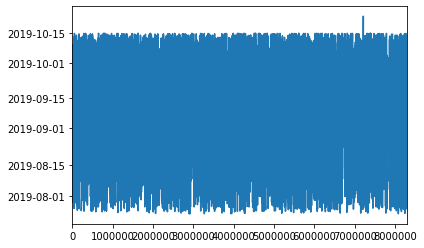

In [18]:
train['timestamp'].plot()

In [19]:
train['world'].value_counts()

MAGMAPEAK       3464962
TREETOPCITY     2453170
CRYSTALCAVES    2368013
NONE               7993
Name: world, dtype: int64

### Train Labels

In [20]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


Here, we can see that the train_labels include the number of correct and incorrect answers for an attempt, as well as the accuracy and accuracy groups. Since we have the accuracy value, you could conceivably treat the problem as a regression problem and predict the accuracy and then map it to the accuracy_group. Based off of the head, we can also see that it has multiple attempts for an installation_id. One thing that we will need to check is if all the installation_ids match between the train and train_labels.

In [21]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [22]:
train_labels['installation_id'].nunique()

3614

When looking at the installation_id in the train_labels, we can see that the number of unique ids is fewer than are in our train dataset. We have data in the train dataset that is not needed, let's deal with this issue.

In [23]:
# create a list of unique installation ids in train_labels
unique_ids_train_labels = list(train_labels['installation_id'].unique())
# filter the train dataset for values whose installation_id appears in train_labels
train = train[train['installation_id'].isin(unique_ids_train_labels)]
# delete unique_ids_train_labels to save memory
del unique_ids_train_labels
# check the number of unique installation_ids in train
train['installation_id'].nunique()

3614

In [24]:
train.shape

(7734558, 11)

In [25]:
train_labels['game_session'].value_counts()

a2cab6136187172e    1
7a7e795c104912df    1
297d6f3e402bf553    1
d5bec8469762410b    1
4026e6b93c668dcb    1
                   ..
ac2de450c359d9ba    1
3bbeff1a10e8e7da    1
f3bdc4ab0e3dbe89    1
b2aaeb10e50eba04    1
46e466e4205cf3bc    1
Name: game_session, Length: 17690, dtype: int64

Interesting, each of the game_session values are unique. This will help distinguish instances where a single installation_ids performed multiple assessments.

In [26]:
train_labels['installation_id'].value_counts()

08987c08    156
f1c21eda    129
9f399a3a     78
8e44d2de     72
96979008     64
           ... 
8aad00ce      1
decd4413      1
00b9d8e6      1
8f2b8c82      1
7e6964ce      1
Name: installation_id, Length: 3614, dtype: int64

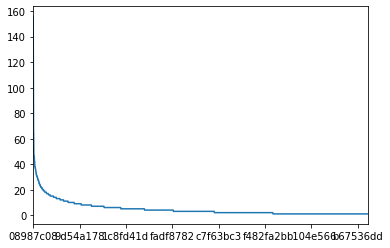

In [27]:
installation_id_attempts = train_labels['installation_id'].value_counts()
installation_id_attempts.plot();

In [28]:
train_labels.describe()

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


The describe method on the train_labels tells us that a lot of kids tend to do fairly well. We can infer this as the 50 percentile mark for accuracy group is 2.5. It  also suggests that the ones that do poorly do really poorly, as the 25% percentile mark for accuracy group is 1. 

In [29]:
train_labels['accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

We can see that the extreme are far more frequent than that inbetweens. There is a greater likelihood that our predictions will either be in accuracy group 3 or in accuracy_group 0.

## Test

Let's take a look at the test data.

In [30]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: int64(3), object(8)
memory usage: 97.1+ MB


In [32]:
test.describe()

,event_count,event_code,game_time
count,1.156414e+06,1.156414e+06,1.156414e+06
mean,1.107075e+02,3.514353e+03,1.869646e+05
std,2.193408e+02,6.802671e+02,1.670162e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.056125e+04
50%,6.000000e+01,4.020000e+03,7.102800e+04
75%,1.240000e+02,4.035000e+03,1.476910e+05
max,4.456000e+03,5.010000e+03,8.859842e+07


The testing data looks the same as the training data. This means we will have to perform similar operations as the training data like adjusting the timestamp and extracting the JSON. The JSON extraction will happen later in the preprocessing.

In [33]:
# deal with timestamp
test['timestamp'] = pd.to_datetime(test['timestamp'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null datetime64[ns, UTC]
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 97.1+ MB


In [34]:
test['installation_id'].nunique()

1000

In [35]:
test[test.type == 'Assessment'][['installation_id']].nunique()

installation_id    1000
dtype: int64

We have 1000 unique installation_ids and they have all take an assessment in the test data. There is no point in looking further at the test data. It has the same structure as the training data, and we will preprocess it in a similar way. Doing further investigation would only lead to biasing our view.

### Sample Submission

The question here, is this file useful at all or is merely for output format. Can it be used in evaluating our model? It is unlikely, but worth checking.

In [36]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
installation_id    1000 non-null object
accuracy_group     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [37]:
# how many installation_ids are unique
sample_submission['installation_id'].nunique()

1000

In [38]:
# are the installation_ids in test and sample_submission the same
len(set.intersection(set(sample_submission['installation_id']), set(test['installation_id'])))

1000

In [39]:
# value_counts of accuracy_group
sample_submission['accuracy_group'].value_counts()

3    1000
Name: accuracy_group, dtype: int64

So the installation_ids are the same between test and sample_submission. However, all the accuracy_groups are 3. So, as expected, this data is useless other than to see the format of the output.

In [40]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


### Specs

In [41]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [42]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [43]:
specs['info'][0]

'The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"'

In [44]:
specs['info'][1]

'The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"'

In [45]:
specs['args'][0]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

In [46]:
specs['args'][1]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

The specs file does not really tell us anything. This can be deleted.

In [47]:
# delete specs
del specs

## Preprocessing

Here, I am going to use code written by another Kaggler in order to preprocess the data. The code goes through and extract the event_data, by iterating through every observation. It gets the: event_data, activities counts, their accuracy_group, accumulated accuracy information.

In [48]:
# From Erik Bruin
#Credits go to Massoud Hosseinali

# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [49]:
# From Erik Bruin
#Credits go to Massoud Hosseinali
# here the get_data function is applyed to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique()):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [50]:
# From Erik Bruin
#Credits go to Massoud Hosseinali

# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)

del compiled_data
new_train.shape

(17690, 102)

In [51]:
# From Erik Bruin
# modified by rahim
new_test = []

for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)

    
new_test = pd.DataFrame(new_test)

In [52]:
new_train.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,0,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,16,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,14,4,1,6,0,0,78,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,193,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,104,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,8,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,78,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,193,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,104,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,16,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,78,0,0,0,0,0,0,0,0,0,195,1611,0,80,0,0,0,193,126,0,110,0,229,0,133,0,0,0,165,0,0,0,0,0,0,0,0,0,0,0,254,104,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,16,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,310,0,0,0,0,0,0,0,0,0,195,1611,0,80,0,0,0,336,126,0,110,0,229,0,133,0,0,0,165,0,0,0,0,0,0,0,0,0,0,0,254,184,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,8,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


In [53]:
new_test.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,0,0,0,0,0,0,88,0,0,0,0,188,0,194,0,0,0,0,0,0,90,135,0,0,1960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,3,1,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,29,11,5,12,0,0,169,0,0,0,317,0,0,0,129,155,162,173,0,73,0,0,0,123,334,110,159,0,64,0,96,108,0,67,348,0,0,0,0,0,0,181,0,0,0,0,178,74,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,18,4,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,16,0,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,10,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,16,0,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,17,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,218,0,0,610,0,0,221,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,18,0,0,0.0,0.000000,0,0,0,0,0,0.0,951


We now have preprocessed both our training data and our testing data. Looking at this, the new_train and new_test groups look at each assessment and include a record of all activity before each assessment. The code that was used in order to get this data, and get the information from the event_data, re-creates the labels for the dataset. Also the train_labels values have been recalculated and we no longer need to use this datafame. However, since we have done this, we need to separate the training columns from the training label. We also need to do the same for the test dataset, as we have put that dataframe through the same preprocessing.

In [54]:
list(new_train.columns.values)

['Clip',
 'Activity',
 'Assessment',
 'Game',
 'Slop Problem',
 'Crystal Caves - Level 3',
 'Crystals Rule',
 'Cauldron Filler (Assessment)',
 'Lifting Heavy Things',
 'Honey Cake',
 'Egg Dropper (Activity)',
 'Tree Top City - Level 3',
 'Bird Measurer (Assessment)',
 'Crystal Caves - Level 1',
 'Pan Balance',
 'Dino Dive',
 'Scrub-A-Dub',
 'Fireworks (Activity)',
 'Heavy, Heavier, Heaviest',
 'Watering Hole (Activity)',
 'Mushroom Sorter (Assessment)',
 'Balancing Act',
 'Cart Balancer (Assessment)',
 'Air Show',
 'Sandcastle Builder (Activity)',
 'Chow Time',
 'Dino Drink',
 'Tree Top City - Level 1',
 'All Star Sorting',
 'Tree Top City - Level 2',
 'Bubble Bath',
 'Chicken Balancer (Activity)',
 'Treasure Map',
 'Leaf Leader',
 'Bottle Filler (Activity)',
 'Crystal Caves - Level 2',
 'Ordering Spheres',
 'Welcome to Lost Lagoon!',
 'Magma Peak - Level 1',
 'Costume Box',
 'Chest Sorter (Assessment)',
 'Happy Camel',
 'Rulers',
 "Pirate's Tale",
 '12 Monkeys',
 'Magma Peak - Level 2

Looking at the above list of columns, the column that needs to be removed (and be used as the label) is the 'accuracy_group'. The other features around here, represent accumulated attempts of previous assessments for the installation_id. The '0','1','2','3', features are a count of how many times the installation_id has previous achieved an accuracy fitting within the accuracy_group.

In [55]:
# create a list of the features
features = list(new_train.columns.values)
features.remove('accuracy_group')
len(features)

101

In [56]:
# removes accuracy_group from the train data
X_train = new_train[features]
# create a variable to contain just the accuracy_group label of the train data
y_train = new_train['accuracy_group']
# remove accuracy_group from the test data
X_test = new_test[features]

Let's just take a quick look at the variables we have created.

In [57]:
X_train.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,0,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,16,0,0,0.00,0.0,0,0,0,0,0.0,647
1,14,4,1,6,0,0,78,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,193,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,104,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,8,1,0,39.00,1.0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,78,0,0,0,0,0,0,0,0,0,115,91,0,0,0,0,0,193,89,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,104,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,16,1,11,65.50,0.5,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,78,0,0,0,0,0,0,0,0,0,195,1611,0,80,0,0,0,193,126,0,110,0,229,0,133,0,0,0,165,0,0,0,0,0,0,0,0,0,0,0,254,104,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,16,2,11,41.25,0.5,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,310,0,0,0,0,0,0,0,0,0,195,1611,0,80,0,0,0,336,126,0,110,0,229,0,133,0,0,0,165,0,0,0,0,0,0,0,0,0,0,0,254,184,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,8,3,12,39.20,0.5,2,0,1,2,1.6,2586


In [58]:
X_test.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,0,0,0,0,0,0,88,0,0,0,0,188,0,194,0,0,0,0,0,0,90,135,0,0,1960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,3,1,0,30.0,1.000000,0,0,0,1,3.0,867
1,29,11,5,12,0,0,169,0,0,0,317,0,0,0,129,155,162,173,0,73,0,0,0,123,334,110,159,0,64,0,96,108,0,67,348,0,0,0,0,0,0,181,0,0,0,0,178,74,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,18,4,7,49.6,0.466667,1,1,2,1,1.6,2718
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,16,0,0,0.0,0.000000,0,0,0,0,0.0,149
3,10,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,16,0,0,0.0,0.000000,0,0,0,0,0.0,233
4,17,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,218,0,0,610,0,0,221,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,18,0,0,0.0,0.000000,0,0,0,0,0.0,951


In [59]:
y_train.head()

0    3
1    0
2    3
3    2
4    3
Name: accuracy_group, dtype: int64

Our training and testing data no longer has the accuracy_group column and our y_train is just the accuracy_group information.

Before moving on to the modelling aspect, let's split our training data. The best course for model evaluation is to test it ourselves, and then to use our best models to come up with predictions and to evaluate by Kaggle's results. One of the reasons for this is, we would want to use the same evaluation metric, the weighted kappa, and in order to do so, we need to have both predictions and actual values for the test group. The second reason for this is Kaggle, has a Kernel submission limit, meaning that we would encounter a timing roadblock there. With this in mind, keeping Kaggle as a final check seems to be our best course of action for evaluation.

In [60]:
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, y_train_train, y_true = train_test_split(
X_train, y_train, test_size=0.25, random_state=42)

In [61]:
X_train_train.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
17236,23,11,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,426,0,0,0,0,0,0,539,302,0,0,329,0,0,1016,0,0,0,0,0,0,0,0,0,1005,0,0,0,0,416,0,0,4,0,0,0,0,6,0,6,200,70,36,0,0,0,0,0,5,273,7,70,50,624,0,204,204,54,71,36,14,42,0,2,31,1138,9,26,1,3,0,7,6,18,2,2,28580.666667,0.444444,1,1,0,1,1.333333,3199
14220,12,2,2,7,0,0,0,0,0,0,0,0,0,0,0,400,166,0,0,101,0,0,0,0,130,92,475,0,612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,0,2,1,1,0,1,119,13,52,0,0,3,0,3,8,126,25,0,8,161,28,120,35,2,14,52,0,23,0,2,36,401,5,34,0,0,3,4,4,16,2,0,41.000000,1.000000,0,0,0,2,3.000000,1294
3280,25,8,6,13,0,0,0,0,0,0,1373,0,0,0,204,168,655,0,0,188,0,0,0,0,73,796,209,0,0,0,386,131,0,76,781,0,0,0,0,0,0,392,0,0,0,0,0,0,20,43,5,0,1,3,22,6,15,394,180,112,10,21,10,21,9,15,473,68,2,71,514,18,399,100,81,180,116,15,52,0,2,188,522,6,176,0,6,21,0,16,36,2,21,43.833333,0.200000,4,1,0,1,0.666667,3913
15279,4,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,1,0,0,0,0,0,0,0,27,0,4,0,0,0,0,0,0,19,0,5,4,23,0,29,0,0,0,4,0,10,0,1,1,7,3,1,0,1,0,0,0,8,1,0,10.000000,0.333333,2,0,0,1,1.000000,140
14727,14,3,0,3,0,0,224,0,0,0,0,0,0,0,0,0,0,66,0,0,0,0,0,123,0,0,0,0,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,132,0,1,1,2,1,0,0,0,0,164,13,16,0,0,0,0,0,3,69,0,10,12,83,0,167,20,0,13,16,0,20,0,0,17,192,4,15,0,0,0,0,1,16,0,0,0.000000,0.000000,0,0,0,0,0.000000,840


In [62]:
y_train_train.head()

17236    0
14220    0
3280     3
15279    3
14727    0
Name: accuracy_group, dtype: int64

In [63]:
X_train_test.head()

,Clip,Activity,Assessment,Game,Slop Problem,Crystal Caves - Level 3,Crystals Rule,Cauldron Filler (Assessment),Lifting Heavy Things,Honey Cake,Egg Dropper (Activity),Tree Top City - Level 3,Bird Measurer (Assessment),Crystal Caves - Level 1,Pan Balance,Dino Dive,Scrub-A-Dub,Fireworks (Activity),"Heavy, Heavier, Heaviest",Watering Hole (Activity),Mushroom Sorter (Assessment),Balancing Act,Cart Balancer (Assessment),Air Show,Sandcastle Builder (Activity),Chow Time,Dino Drink,Tree Top City - Level 1,All Star Sorting,Tree Top City - Level 2,Bubble Bath,Chicken Balancer (Activity),Treasure Map,Leaf Leader,Bottle Filler (Activity),Crystal Caves - Level 2,Ordering Spheres,Welcome to Lost Lagoon!,Magma Peak - Level 1,Costume Box,Chest Sorter (Assessment),Happy Camel,Rulers,Pirate's Tale,12 Monkeys,Magma Peak - Level 2,Flower Waterer (Activity),Bug Measurer (Activity),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,0,1,2,3,accumulated_accuracy_group,accumulated_actions
17553,6,4,4,2,0,0,0,0,0,0,285,0,0,0,3517,0,0,105,0,0,0,0,0,0,0,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,0,0,14,0,0,0,0,0,0,0,70,9,8,0,0,0,0,0,2,84,0,10,46,80,0,73,4,0,9,8,0,16,0,2,13,91,1,8,0,0,0,1,0,16,2,6,32.500000,0.500000,2,0,0,2,1.500000,549
5659,30,9,7,15,0,0,259,0,0,0,56,0,0,0,3964,32,0,33,0,83,0,0,0,26,23,0,195,0,213,0,49,22,0,72,122,0,0,0,0,0,0,122,0,0,0,0,39,0,0,144,5,0,0,4,4,1,2,239,119,78,0,0,2,0,2,15,244,9,5,87,355,11,245,34,30,121,79,7,61,0,2,83,473,10,67,1,1,0,6,0,16,3,31,3624.428571,0.202381,4,2,0,1,0.714286,2546
5954,69,33,23,30,0,0,0,0,0,0,0,0,0,0,0,358,1167,2349,0,862,0,0,0,0,792,893,2469,0,14,0,850,70,0,0,1115,0,0,0,0,0,0,0,0,0,0,0,162,7236,32,40,9,28,7,1,30,3,27,895,275,177,2,21,29,21,28,30,699,125,25,155,877,69,915,212,77,276,177,15,155,0,7,238,2369,16,195,0,14,37,6,14,8,10,54,38.739130,0.280156,13,3,2,5,0.956522,8328
733,264,20,99,50,0,0,15,0,0,0,0,0,0,0,0,0,33,138,0,0,0,0,0,0,395,0,0,0,0,0,679,115,0,0,1248,0,0,0,0,0,0,256,0,0,0,0,61,301,0,280,0,60,0,0,27,9,9,846,413,181,0,27,0,27,0,30,534,30,10,374,978,0,878,207,133,430,184,8,433,0,33,133,519,44,62,5,37,2,48,0,16,33,307,43.080808,0.139141,66,19,7,7,0.545455,6991
10290,5,3,0,4,0,0,0,0,0,0,0,0,0,0,0,159,53,0,0,24,0,0,0,0,75,0,165,0,0,0,173,0,0,0,223,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,1,1,4,2,1,81,7,21,25,11,2,11,2,4,76,13,0,4,89,15,82,20,7,7,23,3,12,0,0,29,136,2,26,0,2,3,0,2,3,0,0,0.000000,0.000000,0,0,0,0,0.000000,729


In [66]:
y_true.head()

17553    3
5659     0
5954     0
733      0
10290    3
Name: accuracy_group, dtype: int64

We have split up the training data, and based off of the heads of the DataFrames or Series, we can see that the indexes match. We are good to move onto the modelling aspect.

An alternative to splitting the training data, is we could use a cross validation, and use grid search for hyperparameter tuning. We would also be able to do using the weighted Kappa as a scoring metric. In order to do this, you would need to create the scorer for the GridSearchCV and can wrap the cohen_kappa_score as the evaluation metric.

## Modelling

There are a number of different classification models which we could use for this evaluation. 

Classifier's we can try:
- Logistic Regression
- Logistic Regression with Elastic Net
- Decision Tree
- Random Forests
- Boosted Trees
- Nearest Neighbor Classification

Out of these classifiers, I expect that we will get the best results with either Random Forests or with a boosted tree classifier.

Let's start by looking at a Logistic Regression. To start, we'll do a straight out of the box Logistic Regression.

In [67]:
# straight logistic regression
clf_lr = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
clf_lr.fit(X_train_train, y_train_train)
y_train_pred = clf_lr.predict(X_train_test)
cohen_kappa_score(y_true, y_train_pred, weights='quadratic')

0.14852691109798255

A straight out of the box Logistic Regression without gave us a Quadratic Weighted Kappa score of 0.148. 

Let's now look at the Logistic Regression using an elastic net penalty with varying l1_ratios.

In [68]:
cohen_kappa_scorer = make_scorer(cohen_kappa_score)
parameters = {'l1_ratio':[0,0.2,0.4,0.6,0.8,1]}
clf = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', random_state=42)
clf_lr = GridSearchCV(clf, parameters, cv=5, scoring=cohen_kappa_scorer)
clf_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(cohen_kappa_score), verbose=0)

In [69]:
clf_lr.cv_results_

{'mean_fit_time': array([4.68522029, 7.41705599, 6.51457047, 6.46791263, 7.5284514 ,
        6.09022441]),
 'std_fit_time': array([0.3030023 , 0.89098011, 0.26337492, 0.24771288, 1.05108525,
        0.3139593 ]),
 'mean_score_time': array([0.00559807, 0.00817947, 0.00548487, 0.00580812, 0.00704627,
        0.00730033]),
 'std_score_time': array([0.0003893 , 0.00478076, 0.00011038, 0.00052283, 0.00088331,
        0.00238699]),
 'param_l1_ratio': masked_array(data=[0, 0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'l1_ratio': 0},
  {'l1_ratio': 0.2},
  {'l1_ratio': 0.4},
  {'l1_ratio': 0.6},
  {'l1_ratio': 0.8},
  {'l1_ratio': 1}],
 'split0_test_score': array([0.0347544, 0.0347544, 0.0347544, 0.0347544, 0.0347544, 0.0347544]),
 'split1_test_score': array([0.03124927, 0.03124927, 0.03124927, 0.03124927, 0.03124927,
        0.03124927]),
 'split2_test_score': array([0.05215062, 0.052150

In [70]:
clf_lr.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
clf_lr.best_score_

0.048028229895943825

This is interesting, our splits showed different weighted kappa test scores, however they were the same across each of the penalties, this suggests that the penalty is not having an impact. The differences in scoring here, could be explained by each split having a different subset of data. When looking at the best model, it showed an l1_ratio=0, which would be the same as using an l2 penalty, using Ridge regularization. When performing the same operation without using GridSearchCV and by using our split training group, a weighted kappa score of 0.0751 was achieved. This was the same for l1_ratios of: 0,0.25,0.5,0.75 and, 1. This supports the earlier finding suggesting that the l1_ratio is not a good hyperparameter to tune on and that it doesn't have an impact here. These attempts performed far worse than our basic Logistic Regression, which had a weighted kappa score of 0.148. 

In [72]:
# Logistic Regression using Elastic Net with various l1_ratio penalties
l1_ratios = [0,0.25,0.5,0.75,1]
for i in l1_ratios:
    clf = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', random_state=42, l1_ratio=i)
    clf.fit(X_train_train, y_train_train)
    y_train_pred = clf.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic')))

Score for 0: 0.07516033817460688
Score for 0.25: 0.07516033817460688
Score for 0.5: 0.07516033817460688
Score for 0.75: 0.07516033817460688
Score for 1: 0.07516033817460688


Now seeing as it favoured the L2 penalty, let's try the Ridge Classifier.

In [73]:
alphas = [1,0.8,0.6,0.4,0.2,0]
for i in alphas:
    clf_ridge = RidgeClassifier(alpha= i,random_state=42)
    clf_ridge.fit(X_train_train, y_train_train)
    y_train_pred = clf_ridge.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic')))    

Score for 1: 0.3805509553491695
Score for 0.8: 0.3805509553491695
Score for 0.6: 0.3812834682181332
Score for 0.4: 0.3812834682181332
Score for 0.2: 0.38075369044551655
Score for 0: 0.37881109183421136


As we can see, the Ridge Classifier performed better than the Logistic Regression with an elastic net penalty and the default Logistic Regression. The scores are different, this shows that there is some impact on the tuning of the alphas, however, it does not have much of an impact and the differences between them are minor.

Let's try the SGDClassifier with varying alphas.

In [74]:
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
for i in alphas:
    clf_sgd = linear_model.SGDClassifier(alpha= i,random_state=42, learning_rate='optimal')
    clf_sgd.fit(X_train_train, y_train_train)
    y_train_pred = clf_sgd.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic')))    

Score for 0.0001: 0.1502421910276236
Score for 0.0005: 0.1301299540623384
Score for 0.001: 0.1578173441043904
Score for 0.005: 0.04348316195535151
Score for 0.01: 0.11079446590851882


Based on the above, we can see that the 0.001 alpha term performed the best. This classifier performed slightly better than our default Logistic Regression but not anywhere near as well as our Ridge Regression, which is still our highest scoring model.

Let's try a Nearest Neighbor Classifier.

In [75]:
neighbors = [3,4,5,6,7,8,9,10,20,50]
for i in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_train, y_train_train)
    y_train_pred = neigh.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic')))    

Score for 3: 0.1779626923558848
Score for 4: 0.18830629917236552
Score for 5: 0.20117876994056993
Score for 6: 0.19579880803814242
Score for 7: 0.1922119518954808
Score for 8: 0.202397456857472
Score for 9: 0.19199909830442474
Score for 10: 0.19671608495239545
Score for 20: 0.15360232191286716
Score for 50: 0.09177524004118354


Based on the above results, our Nearest Neighbor Classifier gives us a higher Weighted Kappa score than the SGD Classifier and Logistic Regression. However, it does not perform as well as the Ridge Classifier. We can see that it performed best when the number of neighbours is between 5-10, where is scored between 0.19 and 0.20. 

Let's move on to Decision Tree Classifiers. For the decision trees, we can hyperparameter tune it by changing either the maximum depth of the tree or the maximum number of leaf nodes. Let's start by changing the max_depth and see what happens and then we'll change the max_leaf_nodes and see what happens.

In [76]:
max_depth = [5,10,20,30,40,50]
for i in max_depth:
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=i, max_leaf_nodes=50)
    clf_dt.fit(X_train_train, y_train_train)
    y_train_pred = clf_dt.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic'))) 

Score for 5: 0.4684636467226614
Score for 10: 0.48498585664023364
Score for 20: 0.48498585664023364
Score for 30: 0.48498585664023364
Score for 40: 0.48498585664023364
Score for 50: 0.48498585664023364


The scoring of our weighted kappa metric is much higher with a decision tree. This blows our previous best model out of the water. However, there was no significant impact by changing the depth. We observed the same score throughout except when max_depth = 5. However, it is close enough to be considered the same. Let's observe the change of the max_leaf_nodes with our max_depth constant.

In [77]:
max_leaf_nodes = [5,10,20,30,40,50]
for i in max_leaf_nodes:
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=50, max_leaf_nodes=i)
    clf_dt.fit(X_train_train, y_train_train)
    y_train_pred = clf_dt.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic'))) 

Score for 5: 0.34303489001188414
Score for 10: 0.4605800221198083
Score for 20: 0.4599031875680737
Score for 30: 0.47596480528840757
Score for 40: 0.4656673737094642
Score for 50: 0.48498585664023364


The change in the max_leaf_nodes does have an impact on our scoring metric. The issue with using the Decision Tree is that we risk overfitting, in this case, we might be better off using a the lowest depth and lowest leaf nodes that yields us the highest result. Let's see how it performs with a depth of 10 and a max_leaf_nodes of 30.

In [78]:
clf_dt = DecisionTreeClassifier(random_state=42, max_depth=10, max_leaf_nodes=30)
clf_dt.fit(X_train_train, y_train_train)
y_train_pred = clf_dt.predict(X_train_test)
print("Score for depth = 10, max_leaf_nodes=30" + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic'))) 

Score for depth = 10, max_leaf_nodes=30: 0.47596480528840757


This performed as well as our max_leaf_nodes of 30 in our original run. It seems pretty clear that the impact of leaf nodes is greater than the impact of depth.

Let's try a Random Forest Classifier. Let's try three different configurations: max_depth = 30 and max_leaf_nodes = 10, max_depth = 30, max_leaf_nodes = 10.

In [79]:
for i in max_depth:
    for j in max_leaf_nodes:
        clf_rf = RandomForestClassifier(random_state=42, max_depth=i, max_leaf_nodes=j)
        clf_rf.fit(X_train_train, y_train_train)
        y_train_pred = clf_rf.predict(X_train_test)
        print("Score for max_depth = " + str(i) + " max_leaf_nodes=" + str(j) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic')))        

Score for max_depth = 5 max_leaf_nodes=5: 0.08363087831377825
Score for max_depth = 5 max_leaf_nodes=10: 0.21969825114763275
Score for max_depth = 5 max_leaf_nodes=20: 0.25033226760385674
Score for max_depth = 5 max_leaf_nodes=30: 0.250425578074987
Score for max_depth = 5 max_leaf_nodes=40: 0.2500710686050116
Score for max_depth = 5 max_leaf_nodes=50: 0.2500710686050116
Score for max_depth = 10 max_leaf_nodes=5: 0.08363087831377825
Score for max_depth = 10 max_leaf_nodes=10: 0.2204255785489314
Score for max_depth = 10 max_leaf_nodes=20: 0.2699126710735319
Score for max_depth = 10 max_leaf_nodes=30: 0.2899538712980788
Score for max_depth = 10 max_leaf_nodes=40: 0.30831595395766165
Score for max_depth = 10 max_leaf_nodes=50: 0.3157492002137193
Score for max_depth = 20 max_leaf_nodes=5: 0.08363087831377825
Score for max_depth = 20 max_leaf_nodes=10: 0.2204255785489314
Score for max_depth = 20 max_leaf_nodes=20: 0.2698164695438605
Score for max_depth = 20 max_leaf_nodes=30: 0.2898033124083

In [80]:
clf_rf = RandomForestClassifier(random_state=42, max_depth=30)
clf_rf.fit(X_train_train, y_train_train)
y_train_pred = clf_rf.predict(X_train_test)
cohen_kappa_score(y_true, y_train_pred, weights='quadratic')

0.4204147745158022

In [81]:
clf_rf = RandomForestClassifier(random_state=42, max_leaf_nodes=10)
clf_rf.fit(X_train_train, y_train_train)
y_train_pred = clf_rf.predict(X_train_test)
cohen_kappa_score(y_true, y_train_pred, weights='quadratic')

0.2204255785489314

The Random Forest Classifier did not perform as well as you would hope and in our current run, the best Decision Tree Classifier has outperformed it. Let's try the AdaBoost Classifier and Gradient Boosting Classifiers.

In [82]:
estimators = [10, 25, 50, 75, 100]
for i in estimators:
    clf_ada = AdaBoostClassifier(random_state=42, n_estimators=i)
    clf_ada.fit(X_train_train, y_train_train)
    y_train_pred = clf_ada.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic'))) 

Score for 10: 0.4534659584768297
Score for 25: 0.48742817412510997
Score for 50: 0.5024718356988901
Score for 75: 0.49938795756160925
Score for 100: 0.5028807532707646


Results for the AdaBoost Classifier are close to the Decision Tree model. We can see that as the number of estimators increases, the quadratic weighted kappa score is generally increasing.

In [83]:
for i in estimators:
    clf_gbc = GradientBoostingClassifier(random_state=42, n_estimators=i)
    clf_gbc.fit(X_train_train, y_train_train)
    y_train_pred = clf_gbc.predict(X_train_test)
    print("Score for " + str(i) + ": " + str(cohen_kappa_score(y_true, y_train_pred, weights='quadratic'))) 

Score for 10: 0.3790871283010018
Score for 25: 0.46294285562802695
Score for 50: 0.5006720436717429
Score for 75: 0.5158706977721195
Score for 100: 0.5222774634881933


The Gradient Boosting Classifier has had pretty good results, it does not perform as well as some of the other models when the number of estimators is 10. However, with the estimators 25 or higher, it performs much closer and slightly better than our previous higher scoring model. This is our best model so far. There is a risk that there is overfitting in some of these models, however, the best way to validate this now is to submit to Kaggle and see what happens.

## Generate Predictions

Now we need to generate our predictions for our X_test data to get our y_pred to submit to Kaggle. For this we will use the Gradient Boosting Classifier with the number of estimators = 100.

In [84]:
clf_gbc = GradientBoostingClassifier(random_state=42, n_estimators=100)
clf_gbc.fit(X_train, y_train)
y_pred = clf_gbc.predict(X_test)

In [85]:
y_pred

array([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 1, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1,
       0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0,
       3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0,
       3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,

In [87]:
type(y_pred)

numpy.ndarray

In [91]:
submission = pd.DataFrame(sample_submission['installation_id'])
y_pred = pd.DataFrame({'accuracy_group':y_pred[:]})

,accuracy_group
0,3
1,3
2,3
3,3
4,3
...,...
995,3
996,0
997,3
998,3


In [97]:
submission = submission.join(y_pred)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [99]:
submission.set_index('installation_id', inplace=True)

In [100]:
submission.to_csv('submission.csv')

## Conclusions and Final Thoughts

Overall, we found the best model from our experimentation is be the Gradient Boosted Classifier with 100 estimators. This yielded us a Quadratic Weighted Kappa score of approximately, 0.52.

In order to further improve this model, there are a couple things we could try. We could try some alternative classifier like CatBoost (which other Kagglers seemed to have success with) or we could try a Neural Network Classifier. In addition to that, for our modelling purposes, we were using approximately 100 different features logging the different events that occurred prior to the assessments. We could try to do some dimensionality reduction to see whether or not that helps us create a better performing and more generalized model. Using so many features, it would not be surprising to find that our model has overfit. This is something we could determine once we have submitted our results and a kernel for Kaggle to evaluate. Furthermore, we can always improve by refactoring our code and making it more efficient and simplifying things. 

The main next step from this point, is to submit the model to Kaggle, see what the results are and refine to improve the model.

## Sources:

While working on this project, I read some of the notebooks that other Kagglers had produced for their submission. In the preprocessing, I utilized and referred to code by two other Kagglers and would like to give credit to them here.

Erik Bruin : https://www.kaggle.com/erikbruin/data-science-bowl-2019-data-exploration

Massoud Hosseinali :https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model